# CNN on CWT of original data

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import defaultdict
import pywt
import scaleogram as scg
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
from sklearn.metrics import mean_squared_error 

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import the written functions
from CGMfunctions import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from sklearn.utils.class_weight import compute_class_weight


## Anderson2016 data
This study was designed to test a closed-loop control-to-range artificial pancreas (AP) system. <br>
Sample size: 30 (phase 1), 14 (phase 2) <br>
Diabetes Type: Type 1 <br>
Population Group: Adult 18+ <br>
CGM device: Dexcom G4 Platinum <br>
Duration: 6-9 weeks (Phase 1), 20+ weeks (Phase 2) <br> 
Interval: 5 mins

In [2]:
Anderson2016 = pd.read_csv("./data/Anderson2016_processed.csv",header = 0,index_col=False)  
Anderson2016.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
Anderson2016.head(3)

,id,Time,Glucose
0,1,2013-09-29 17:36:48,194
1,1,2013-09-29 17:41:48,204
2,1,2013-09-29 17:46:48,201


### Tsalikian 2005 data
The purpose of this study was to find out how often low blood sugar (hypoglycemia) occurs during the night after exercise in late afternoon for children aged 10 to 18 with type 1 diabetes. The total sample size was 50 participants. The OneTouch Ultra Meter was used to continuously monitor glucose levels during two seperate 24 hours periods. <br>
Sample size: 50 <br>
Diabetes Type: Type 1 <br>
Population Group: Children (10-18) <br>
CGM device: OneTouch Ultra Meter <br>
Duration: 48 hours, every 5 minutes <br> 


In [7]:
tsalikian2005 = pd.read_csv("./data/Tsalikian2005_processed.csv",header = 0,index_col=False)  
tsalikian2005.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
tsalikian2005.id.unique()

array([ 7, 43,  2, 27, 38, 15, 16, 19, 22, 32, 11,  8, 20, 44, 35, 18, 42,
       17, 36, 46, 33, 48,  5, 53, 14, 40, 13, 41, 25, 26, 28,  3, 50, 29,
       24, 12,  9, 23,  1, 10, 54, 39,  4, 37, 31, 30,  6, 52, 21, 45],
      dtype=int64)

In [8]:
dfs_good = data_subject_info(tsalikian2005)
allsub_daily_dict = split_by_date_allsub(dfs_good)

There are in total  50 subjects.
The information for subject:  1
There are missing values in the dataset:
- Time: 24 missing values
Missing time range is  [(168, 179), (24626, 24637)]
Records per day:
          Date  Number of Records
0   2000-04-01                288
1   2000-04-02                144
2   2000-04-07                298
3   2000-04-08                174
4   2013-09-29                 77
..         ...                ...
93  2014-02-22                 28
94  2014-02-23                287
95  2014-02-24                279
96  2014-02-25                285
97  2014-02-26                 96

[98 rows x 2 columns]

Total number of days: 98
The information for subject:  2
There are no missing values in the dataset.
Records per day:
           Date  Number of Records
0    2000-02-06                212
1    2000-02-07                146
2    2000-02-15                298
3    2000-02-16                194
4    2013-08-26                 23
..          ...                ...
247 

In [24]:
allsub_daily_144_dict = filter_dfdict_by_record_count(allsub_daily_dict,144) 
print(len(allsub_daily_144_dict))
allsub_chunk_dict = split_crossover_timechunk(allsub_daily_144_dict)
allsub_chunk_dict2 = remove_dup_dicts(allsub_chunk_dict)
allsub_6hours_dict = split_into_6hour_dict(allsub_chunk_dict2)
allsub_6hour_combined = combine_3keys(allsub_6hours_dict)
allsub_6hour_72_combined = filter_6hourdict_by_record_count(allsub_6hour_combined,72)
allsub_6hour_2keydict = split_combined_3keys(allsub_6hour_72_combined)

1321


In [25]:
allsub_6hour_2keydict_labels = label_glucose(allsub_6hour_2keydict) 
original_label_df = label_summary_df(allsub_6hour_2keydict_labels)
original_label_df.head(3)
original_label_df['timesegment'] = original_label_df['subject'].apply(lambda x: x.split('_')[-1])
summary = original_label_df.groupby('timesegment')['Label'].sum().reset_index()
summary

,timesegment,Label
0,00:00-05:59,432
1,06:00-11:59,339
2,12:00-17:59,583
3,18:00-23:59,597


In [ ]:
plot_subject_glucose_histograms(allsub_6hours_dict, 8)

In [26]:
def extract_glucose(allsub_6hour_2keydict):
    glucoses= {}
    for key, dict in allsub_6hour_2keydict.items():
        middle_dict = {}
        for subject, df in dict.items():
            middle_dict[subject] = df['Glucose'].values
        glucoses[key] = middle_dict
    return glucoses

org_glucose = extract_glucose(allsub_6hour_2keydict)

In [28]:
wavelet = 'morl'  # Complex Morlet wavelet 'mexh' 'gaus' 'cmor' 
scales = np.arange(1, 128)
coefficients_dict, frequencies_dict = get_cwt_allsub_daily(org_glucose,scales,wavelet)

In [29]:
coeff_1key_dict = {}
for date, subjects_dict in coefficients_dict.items():
    for subject, data in subjects_dict.items():
        coeff_1key_dict[subject] = data
coeff_dataframes = list(coeff_1key_dict.values())
coeff_array = np.stack(coeff_dataframes, axis=0)
print(coeff_array.shape)

(9513, 127, 72)


In [30]:
net_input_data = np.zeros((coeff_array.shape[0], 128, 128, 3))
for i in range(coeff_array.shape[0]):
    input_for_densenet = prepare_input_net(coeff_array[i])
    net_input_data[i] = input_for_densenet

labels = original_label_df['Label'].values
labels = np.expand_dims(labels, axis=-1) 

In [31]:
# save the data
np.save('./data/net_input_data_tsalikian_original_morl.npy',net_input_data)
np.save('./data/labels_tsalikian_original_morl.npy',labels)

In [2]:
# load the data
#net_input_data = np.load('./data/net_input_data_tsalikian_original.npy')
#labels = np.load('./data/labels_tsalikian_original.npy')

In [32]:
x_train, x_temp, y_train, y_temp = train_test_split(net_input_data, labels, stratify = labels, test_size=0.3, random_state=118)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=716)

In [33]:
y_train_weight =  np.concatenate(y_train).ravel().tolist()
class_weights = compute_class_weight(class_weight='balanced',classes = np.unique(y_train_weight), y =y_train_weight)
class_weights =  {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.629038352541092, 1: 2.4374084919472914}

In [2]:
import keras
from keras.layers import Dense, Flatten, Input, Activation, Add,AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.models import Sequential
from keras.callbacks import History 
from keras.models import Model
from keras.callbacks import *
from keras.layers import Input, Dense, Flatten,Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Add, AveragePooling2D
from keras.activations import *
#from keras.datasets import cifar,cifar10,cifar100
from keras.utils import to_categorical, plot_model
from keras.optimizers import *

## ResNet

In [18]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

def conv_block(x, filters, kernel_size, strides, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=(1, 1))
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=1000):
    inputs = Input(shape=input_shape)
    
    # initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # conv block 1
    x = projection_block(x, filters=64, strides=(1, 1))
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # conv block 2
    x = projection_block(x, filters=128, strides=(2, 2))
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # conv block 3
    x = projection_block(x, filters=256, strides=(2, 2))
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # conv block 4
    x = projection_block(x, filters=512, strides=(2, 2))
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

epochs = 3
num_classes =1
OPT = Adam(0.001)
model1 = ResNet50(input_shape=(128, 128, 3), num_classes=2)
model1.compile(loss='binary_crossentropy', optimizer=OPT, metrics=['binary_crossentropy', 'mse','acc'])
hist_classifier = model1.fit(x_train,y_train, batch_size=64, epochs=epochs, validation_data=(x_val, y_val))


Epoch 1/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 641s 6s/step - acc: 0.2152 - binary_crossentropy: 0.6996 - loss: 0.6996 - mse: 0.7848 - val_acc: 0.2053 - val_binary_crossentropy: 0.5272 - val_loss: 0.5272 - val_mse: 0.7947
Epoch 2/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 594s 6s/step - acc: 0.1988 - binary_crossentropy: 0.4376 - loss: 0.4376 - mse: 0.8012 - val_acc: 0.2053 - val_binary_crossentropy: 0.4965 - val_loss: 0.4965 - val_mse: 0.7947
Epoch 3/3
105/105 ━━━━━━━━━━━━━━━━━━━━ 589s 6s/step - acc: 0.2038 - binary_crossentropy: 0.4820 - loss: 0.4820 - mse: 0.7962 - val_acc: 0.2053 - val_binary_crossentropy: 0.4035 - val_loss: 0.4035 - val_mse: 0.7947


In [20]:
y_pred_prob = model1.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print_nn_result(y_test,y_pred)

45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 584ms/step
Confusion Matrix:
[[1135    0]
 [ 292    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1135
           1       0.00      0.00      0.00       292

    accuracy                           0.80      1427
   macro avg       0.40      0.50      0.44      1427
weighted avg       0.63      0.80      0.70      1427


Accuracy: 0.80
Precision: 0.00
Recall/Sensitivity: 0.00
Specificity: 1.00
F1-score: 0.00
ROC AUC: 0.50


## CNN

In [34]:

history = History()
 
img_x = 128
img_y = 128
img_z = 3
input_shape = (img_x, img_y, img_z)
learning_rate = 0.001
 
num_classes = 2
batch_size = 64
epochs = 30

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
 
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


 
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
          class_weight=class_weights,
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.5333 - loss: 1.7045 - val_accuracy: 0.7358 - val_loss: 0.6562
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7169 - loss: 0.5886 - val_accuracy: 0.7737 - val_loss: 0.4754
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7573 - loss: 0.5215 - val_accuracy: 0.7744 - val_loss: 0.4547
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7651 - loss: 0.5150 - val_accuracy: 0.8241 - val_loss: 0.3994
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7790 - loss: 0.4886 - val_accuracy: 0.6811 - val_loss: 0.6403
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7561 - loss: 0.5076 - val_accuracy: 0.6559 - val_loss: 0.6594
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7509 - loss: 0.5157 - val_accuracy: 0.7730 - val_loss: 0.4650
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7668 - loss: 0.4980 - val_accu

In [35]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print_nn_result(y_test,y_pred)

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step
Confusion Matrix:
[[909 226]
 [ 59 233]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1135
           1       0.51      0.80      0.62       292

    accuracy                           0.80      1427
   macro avg       0.72      0.80      0.74      1427
weighted avg       0.85      0.80      0.81      1427


Accuracy: 0.80
Precision: 0.51
Recall/Sensitivity: 0.80
Specificity: 0.80
F1-score: 0.62
ROC AUC: 0.80


Res50

In [6]:
cl_in      = Input(shape=[128,128,3])
cl_conv_1  = Conv2D(64, 3, strides=2, activation='selu', padding='same', kernel_initializer='lecun_normal')(cl_in)
cl_pl_1    = MaxPooling2D()(cl_conv_1)
cl_res_1_1 = BatchNormalization()(cl_pl_1)
cl_res_1_1 = Activation('relu')(cl_res_1_1)
cl_res_1_1 = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_1_1)
cl_res_1_2 = BatchNormalization()(cl_res_1_1)
cl_res_1_2 = Activation('relu')(cl_res_1_2)
cl_res_1_2 = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_1_2)
cl_res_1_a = Add()([cl_pl_1, cl_res_1_2])
cl_res_2_1 = BatchNormalization()(cl_res_1_a)
cl_res_2_1 = Activation('relu')(cl_res_2_1)
cl_res_2_1 = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_2_1)
cl_res_2_2 = BatchNormalization()(cl_res_2_1)
cl_res_2_2 = Activation('relu')(cl_res_2_2)
cl_res_2_2 = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_2_2)
cl_res_2_a = Add()([cl_res_1_a, cl_res_2_2])
cl_res_3_1 = BatchNormalization()(cl_res_2_a)
cl_res_3_1 = Activation('relu')(cl_res_3_1)
cl_res_3_1 = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_3_1)
cl_res_3_2 = BatchNormalization()(cl_res_3_1)
cl_res_3_2 = Activation('relu')(cl_res_3_2)
cl_res_3_2 = Conv2D(64, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_3_2)
cl_res_3_a = Add()([cl_res_2_a, cl_res_3_2])
cl_conv_2  = Conv2D(128, 3, strides=2, padding='same', kernel_initializer='lecun_normal')(cl_res_3_a)
cl_conv_2  = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_conv_2)
cl_res_4_1 = BatchNormalization()(cl_conv_2)
cl_res_4_1 = Activation('relu')(cl_res_4_1)
cl_res_4_1 = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_4_1)
cl_res_4_2 = BatchNormalization()(cl_res_4_1)
cl_res_4_2 = Activation('relu')(cl_res_4_2)
cl_res_4_2 = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_4_2)
cl_res_4_a = Add()([cl_conv_2, cl_res_4_2])
cl_res_5_1 = BatchNormalization()(cl_res_4_a)
cl_res_5_1 = Activation('relu')(cl_res_5_1)
cl_res_5_1 = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_5_1)
cl_res_5_2 = BatchNormalization()(cl_res_5_1)
cl_res_5_2 = Activation('relu')(cl_res_5_2)
cl_res_5_2 = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_5_2)
cl_res_5_a = Add()([cl_res_4_a, cl_res_5_2])
cl_res_6_1 = BatchNormalization()(cl_res_5_a)
cl_res_6_1 = Activation('relu')(cl_res_6_1)
cl_res_6_1 = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_6_1)
cl_res_6_2 = BatchNormalization()(cl_res_6_1)
cl_res_6_2 = Activation('relu')(cl_res_6_2)
cl_res_6_2 = Conv2D(128, 3, strides=1, padding='same', kernel_initializer='lecun_normal')(cl_res_6_2)
cl_res_6_a = Add()([cl_res_5_a, cl_res_6_2])
cl_pl_2    = AveragePooling2D(pool_size=(2, 2))(cl_res_6_a)
cl_flatten = Flatten()(cl_pl_2)
cl_fc100   = Dense(2, activation='softmax')(cl_flatten)
classifier_ReLUBN = Model(cl_in, cl_fc100)
#plot_model(classifier_ReLUBN, 'resnet_ReLUBN.png', show_layer_names=False)
classifier_ReLUBN.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ add[0][0]         │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],      

 Total params: 1,351,298 (5.15 MB)

 Trainable params: 1,348,994 (5.15 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [36]:
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_val = x_val.astype('float32')
 
# y_train = keras.utils.to_categorical(y_train, num_classes)
# #y_test = keras.utils.to_categorical(y_test, num_classes)
# y_val = keras.utils.to_categorical(y_val, num_classes)
epochs = 60
OPT = Adam(0.001)
classifier_ReLUBN.compile(loss='binary_crossentropy', optimizer=OPT, metrics=['binary_crossentropy', 'mse','acc'])
hist_classifier_ReLUBN_Res = classifier_ReLUBN.fit(x_train,y_train, batch_size=64, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/60
105/105 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - acc: 0.7596 - binary_crossentropy: 1.7440 - loss: 1.7440 - mse: 0.2165 - val_acc: 0.7064 - val_binary_crossentropy: 0.7092 - val_loss: 0.7092 - val_mse: 0.2390
Epoch 2/60
105/105 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - acc: 0.7720 - binary_crossentropy: 0.9401 - loss: 0.9401 - mse: 0.1951 - val_acc: 0.8143 - val_binary_crossentropy: 0.4822 - val_loss: 0.4822 - val_mse: 0.1428
Epoch 3/60
105/105 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - acc: 0.8094 - binary_crossentropy: 1.1342 - loss: 1.1342 - mse: 0.1645 - val_acc: 0.7975 - val_binary_crossentropy: 0.6753 - val_loss: 0.6753 - val_mse: 0.1895
Epoch 4/60
105/105 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.7982 - binary_crossentropy: 1.6988 - loss: 1.6988 - mse: 0.1812 - val_acc: 0.8381 - val_binary_crossentropy: 0.7260 - val_loss: 0.7260 - val_mse: 0.1412
Epoch 5/60
105/105 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - acc: 0.8135 - binary_crossentropy: 0.5079 - loss: 0.5079 - mse: 0.1480 - val_acc: 0.8

In [21]:
y_pred_prob2 = classifier_ReLUBN.predict(x_test)
y_pred2 = np.argmax(y_pred_prob2, axis=1)

print_nn_result(y_test,y_pred2)

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step
Confusion Matrix:
[[1134    1]
 [ 276   16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1135
           1       0.94      0.05      0.10       292

    accuracy                           0.81      1427
   macro avg       0.87      0.53      0.50      1427
weighted avg       0.83      0.81      0.73      1427


Accuracy: 0.81
Precision: 0.94
Recall/Sensitivity: 0.05
Specificity: 1.00
F1-score: 0.10
ROC AUC: 0.53


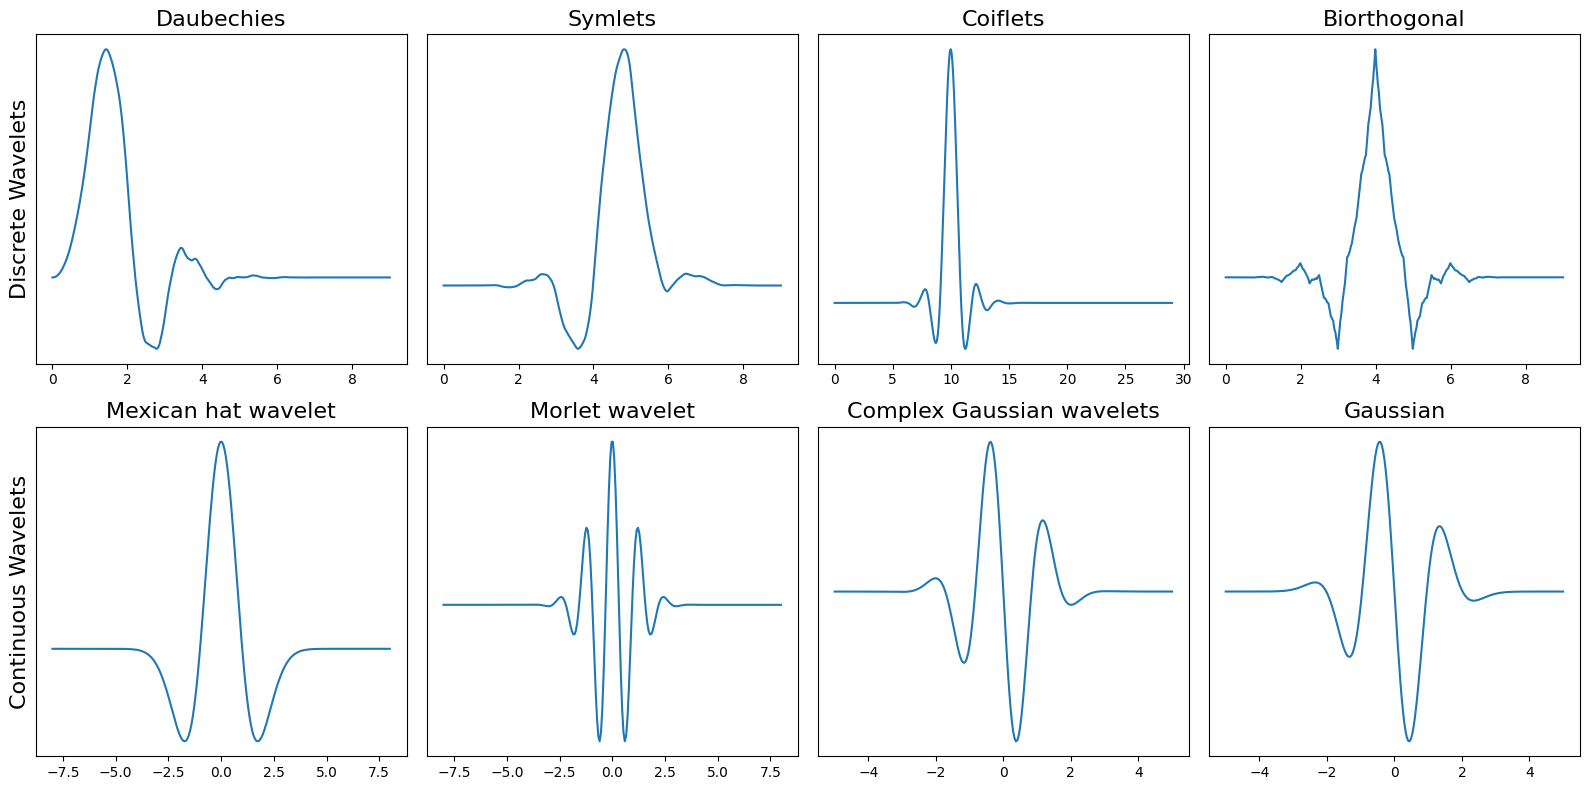

In [70]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()